Branching GP Regression on synthetic data
--

*Alexis Boukouvalas, 2017*

Branching GP regression with Gaussian noise on the hematopoiesis data described in the paper "BGP: Gaussian processes for identifying branching dynamics in single cell data".

This notebook shows how to build a BGP model and plot the posterior model fit and posterior branching times.

In [1]:
import pickle

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from BranchedGP import VBHelperFunctions as bplot

plt.style.use("ggplot")
%matplotlib inline

### Load the data
1. Monocle has already been run on the data. The first columns contains the state assigned by the DDRTree algorithm to each cell.
1. Second column is the gene time.
1. All other columns are the 40 genes. The first 10 branch early, then 20 branch late and 10 do not branch.

In [2]:
datafile = "syntheticdata/synthetic20.csv"
data = pd.read_csv(datafile, index_col=[0])
G = data.shape[1] - 2  # all data - time columns - state column
Y = data.iloc[:, 2:]
trueBranchingTimes = np.array([float(Y.columns[i][-3:]) for i in range(G)])

In [3]:
data.head()

,MonocleState,Time,Y0_0.1,Y1_0.1,Y2_0.1,Y3_0.1,Y4_0.1,Y5_0.1,Y6_0.1,Y7_0.1,...,Y30_1.1,Y31_1.1,Y32_1.1,Y33_1.1,Y34_1.1,Y35_1.1,Y36_1.1,Y37_1.1,Y38_1.1,Y39_1.1
0,3.0,0.969910,0.875437,-0.748863,-1.016271,-2.678964,0.821025,1.604661,-1.907981,-0.095716,...,-0.359742,1.970076,-1.807038,1.342145,-0.095995,2.464551,-0.620385,2.007109,0.041135,-0.757357
1,1.0,0.122038,-0.907147,-1.580759,-0.400795,-2.179394,-0.516783,0.213534,-0.430098,-0.451737,...,-0.878141,0.028067,-0.015040,-1.735634,0.030597,0.208739,-0.595135,0.955642,-0.271234,-1.326305
2,2.0,0.271349,-1.226234,-1.084321,0.117731,-1.887095,-0.993914,-0.020810,-0.175115,-0.755351,...,-0.808743,0.639339,0.193315,-1.258822,0.003173,0.393885,-0.809217,1.206395,-0.225219,-1.317605
3,3.0,0.520068,0.430385,-1.693506,-1.441682,-2.874642,0.392821,1.014923,-1.874323,0.200560,...,-0.493171,1.387135,-0.357995,-0.524626,-0.024159,1.464900,-0.974829,1.107700,0.169320,-1.082405
4,1.0,0.212339,-1.076617,-1.211521,0.030578,-1.960545,-0.820111,0.004572,-0.174163,-0.675381,...,-0.903597,0.393455,0.146080,-1.535963,-0.042453,0.294899,-0.604018,1.031153,-0.297941,-1.359075


# Plot the data

Text(0.5, 0.98, 'Branching genes, location=1.1 indicates no branching')

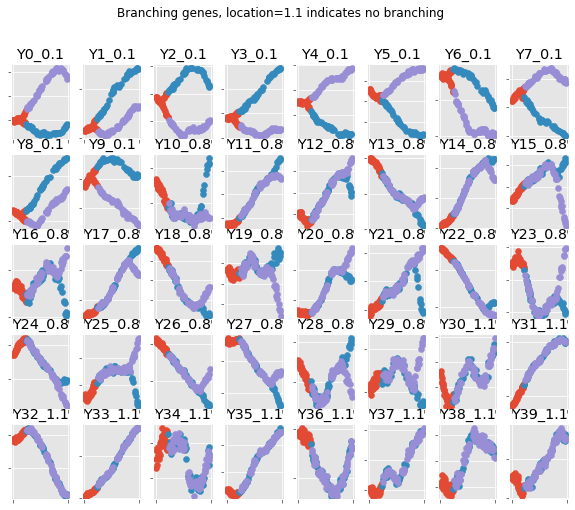

In [4]:
f, ax = plt.subplots(5, 8, figsize=(10, 8))
ax = ax.flatten()
for i in range(G):
    for s in np.unique(data["MonocleState"]):
        idxs = s == data["MonocleState"].values
        ax[i].scatter(data["Time"].loc[idxs], Y.iloc[:, i].loc[idxs])
        ax[i].set_title(Y.columns[i])
        ax[i].set_yticklabels([])
        ax[i].set_xticklabels([])
f.suptitle("Branching genes, location=1.1 indicates no branching")

# Run the BGP model
Run script `runsyntheticData.py` to obtain a pickle file with results.
This script can take ~10 to 20 minutes depending on your hardware.
It performs a gene-by-gene branch model fitting.

# Plot BGP posterior fit
Plot posterior fit.

In [5]:
r = pickle.load(open("syntheticdata/syntheticDataRun.p", "rb"))

In [6]:
r.keys()

dict_keys(['M', 'maxiter', 'Bsearch', 'gpmodels'])

<ipython-input-7-fcb3f147f714>:3: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  GPy = Y.iloc[:, g][:, None]


True branching time 0.1 BGP Maximum at b=0.10


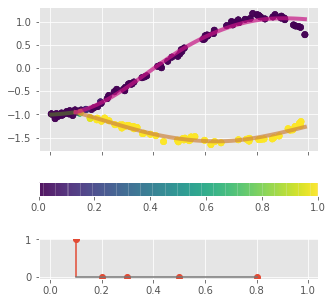

In [7]:
# plot fit for a gene
g = 0
GPy = Y.iloc[:, g][:, None]
GPt = data["Time"].values
globalBranching = data["MonocleState"].values.astype(int)
bmode = r["Bsearch"][np.argmax(r["gpmodels"][g]["loglik"])]
print("True branching time", trueBranchingTimes[g], "BGP Maximum at b=%.2f" % bmode)
_ = bplot.PlotBGPFit(GPy, GPt, r["Bsearch"], r["gpmodels"][g])

We can also plot with the predictive uncertainty of the GP.
The dashed lines are the 95% confidence intervals.

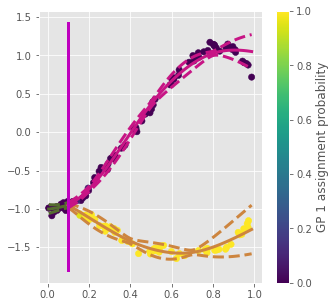

In [8]:
g = 0
bmode = r["Bsearch"][np.argmax(r["gpmodels"][g]["loglik"])]
pred = r["gpmodels"][g]["prediction"]  # prediction object from GP
_ = bplot.plotBranchModel(
    bmode,
    GPt,
    GPy,
    pred["xtest"],
    pred["mu"],
    pred["var"],
    r["gpmodels"][g]["Phi"],
    fPlotPhi=True,
    fColorBar=True,
    fPlotVar=True,
)

# Plot posterior
Plotting the posterior alongside the true branching location.

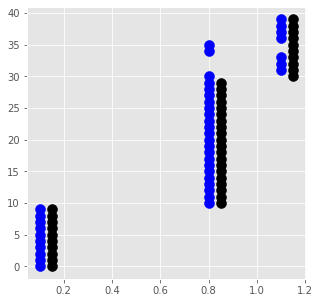

In [9]:
fs, ax = plt.subplots(1, 1, figsize=(5, 5))
for g in range(G):
    bmode = r["Bsearch"][np.argmax(r["gpmodels"][g]["loglik"])]
    ax.scatter(bmode, g, s=100, color="b")  # BGP mode
    ax.scatter(trueBranchingTimes[g] + 0.05, g, s=100, color="k")  # True